# TSNE & visualization workflow
This notebook reproduces and extends the visualisations in `visualize.ipynb`.
It loads pretrained embeddings (flattened 100x256 -> 25600 dim), loads metadata CSVs, performs PCA preprocessing, runs UMAP with parameter sweeps, creates static matplotlib plots and interactive Plotly visualizations, and saves outputs for downstream analysis.

In [1]:
# --- Imports and plotting backend ---
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE, MDS
from sklearn.manifold import trustworthiness
from sklearn.metrics import pairwise_distances
import os

# plotting defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# --- File paths and loading raw data ---
# Edit these paths if your files are in other locations
# EMBED_PKL = './Embeddings/fixedlen_512/Caduceus_FixedLen_512.pkl'
EMBED_PKL = './Embeddings/fixedlen_25000/Caduceus_FixedLen_25000_avg.pkl'
DATA_DRIVEN_CSV = './Data/coords_with_data_driven.csv'
KOPPEN_CSV = './Data/coords_with_koppen_geiger.csv'
BIOCLIM_CSV = './Data/coords_with_bioclim.csv'
OUT_DIR = './Results/visualize_tsne'
os.makedirs(OUT_DIR, exist_ok=True)

print('Loading embeddings...')
with open(EMBED_PKL, 'rb') as f:
    embeddings_dict = pickle.load(f)

print('Number of keys in embeddings:', len(embeddings_dict))
print('Sample key examples:', list(embeddings_dict.keys())[:5])

print('\nLoading metadata...')
data_driven = pd.read_csv(DATA_DRIVEN_CSV)
koppen = pd.read_csv(KOPPEN_CSV)
bioclim = pd.read_csv(BIOCLIM_CSV)

print('data_driven rows:', len(data_driven))
print('koppen rows:', len(koppen))
print('bioclim rows:', len(bioclim))

Loading embeddings...
Number of keys in embeddings: 1135
Sample key examples: ['88', '108', '139', '159', '265']

Loading metadata...
data_driven rows: 1135
koppen rows: 1135
bioclim rows: 1135


In [3]:
# --- Construct embeddings array from pickle (reshape stacked arrays) ---
# Expect each embeddings_dict[k] to be shape (100, 256) or similar; flatten to 25600
keys = list(embeddings_dict.keys())
embed_list = []
for k in keys:
    arr = np.array(embeddings_dict[k])
    embed_list.append(arr.reshape(-1))

embed_arr = np.vstack(embed_list)
embed_keys = np.array(keys)
print('embed_arr.shape =', embed_arr.shape)
print('embed_keys.shape =', embed_keys.shape)

embed_arr.shape = (1135, 25600)
embed_keys.shape = (1135,)


In [4]:
# --- Build metadata join (map embed_keys to data_driven and koppen_geiger rows) ---
# Ensure types match
try:
    # metadata IID likely numeric strings—coerce to str for matching
    data_driven['IID'] = data_driven['IID'].astype(str)
    koppen['IID'] = koppen['IID'].astype(str)
except Exception:
    pass

# Build a metadata dataframe aligned with embed_keys
meta_rows = []
for k in embed_keys:
    k_str = str(k)
    row_dd = data_driven[data_driven['IID'] == k_str]
    row_kp = koppen[koppen['IID'] == k_str]
    meta = {
        'embed_key': k_str,
        'data_driven_index': (row_dd.index[0] if len(row_dd) > 0 else np.nan),
        'koppen_index': (row_kp.index[0] if len(row_kp) > 0 else np.nan)
    }
    # pull a few useful labels if present
    if len(row_dd) > 0:
        meta.update({
            'KM12_value': row_dd.iloc[0].get('KM12_value', None),
            'ISO16_value': row_dd.iloc[0].get('ISO16_value', None),
            'KM30_value': row_dd.iloc[0].get('KM30_value', None),
            'RF30_value': row_dd.iloc[0].get('RF30_value', None)
        })
    if len(row_kp) > 0:
        meta.update({'Koppen-Geiger-Name': row_kp.iloc[0].get('Koppen-Geiger-Name', None)})
    meta_rows.append(meta)

meta_df = pd.DataFrame(meta_rows)
print('meta_df.shape =', meta_df.shape)
meta_df.head()

meta_df.shape = (1135, 8)


,embed_key,data_driven_index,koppen_index,KM12_value,ISO16_value,KM30_value,RF30_value,Koppen-Geiger-Name
0,88,0,0,5,2,17,2,Cfb
1,108,1,1,10,5,3,2,Cfb
2,139,2,2,10,5,3,2,Cfb
3,159,3,3,5,2,17,2,Cfb
4,265,4,4,5,5,13,2,Cfb


In [5]:
# --- Filter classes and indices (count thresholds, Koppen-Geiger modifications) ---
# 1. Filter by KM12_value requiring at least 10 samples per class
# class_counts = meta_df['KM12_value'].value_counts(dropna=True)
# valid_classes = class_counts[class_counts >= 10].index.tolist()
# print('Valid KM12 classes (>=10):', valid_classes)

# valid_indices = meta_df[meta_df['KM12_value'].isin(valid_classes)].index.to_numpy()
# filtered_embed_arr = embed_arr[valid_indices]
# filtered_embed_keys = embed_keys[valid_indices]
# filtered_meta_df = meta_df.iloc[valid_indices].reset_index(drop=True)

# class_counts = meta_df['ISO16_value'].value_counts(dropna=True)
# valid_classes = class_counts[class_counts >= 10].index.tolist()
# print('Valid KM12 classes (>=10):', valid_classes)

# valid_indices = meta_df[meta_df['ISO16_value'].isin(valid_classes)].index.to_numpy()
# filtered_embed_arr = embed_arr[valid_indices]
# filtered_embed_keys = embed_keys[valid_indices]
# filtered_meta_df = meta_df.iloc[valid_indices].reset_index(drop=True)

# --- Koppen-Geiger filtering: start from full meta_df, not filtered_meta_df ---
# Add Koppen-Geiger-Name-Modified column to meta_df (not filtered_meta_df)
kg_names = koppen.set_index('IID')['Koppen-Geiger-Name'].astype(str)
kg_mod = kg_names.copy()
kg_mod = kg_mod.replace({'Csa': 'Cs', 'Csb': 'Cs'})
kg_mod = kg_mod.replace({'Dfc': None, 'Dsb': None, 'ET': None, 'Dsc': None, 'BWh': None, 'Cfc': None, 'BWk': None})
meta_df['Koppen-Geiger-Name-Modified'] = meta_df['embed_key'].map(kg_mod)

# Filter to only rows with valid KG classes (not null, not 'nan')
valid_kg_mask = meta_df['Koppen-Geiger-Name-Modified'].notnull() & (meta_df['Koppen-Geiger-Name-Modified'] != 'nan')
kg_filtered_df = meta_df[valid_kg_mask].reset_index(drop=True)
kg_filtered_embed_arr = embed_arr[valid_kg_mask.values]
kg_filtered_embed_keys = embed_keys[valid_kg_mask.values]

# Filter KG classes by count threshold (e.g. >=10)
kg_class_counts = kg_filtered_df['Koppen-Geiger-Name-Modified'].value_counts(dropna=True)
valid_kg_classes = kg_class_counts[kg_class_counts >= 1].index.tolist()
print('Valid KG classes (>=10):', valid_kg_classes)
valid_kg_class_mask = kg_filtered_df['Koppen-Geiger-Name-Modified'].isin(valid_kg_classes)
filtered_meta_df = kg_filtered_df[valid_kg_class_mask].reset_index(drop=True)
filtered_embed_arr = kg_filtered_embed_arr[valid_kg_class_mask.values]
filtered_embed_keys = kg_filtered_embed_keys[valid_kg_class_mask.values]

print('kg_filtered_embed_arr.shape =', filtered_embed_arr.shape)

# filtered_meta_df etc. (KM12) are for KM12-based analysis; kg_filtered_df etc. are for KG-based analysis

Valid KG classes (>=10): ['Cfb', 'Dfb', 'Cs', 'Cfa', 'BSk', 'Dfa']
kg_filtered_embed_arr.shape = (1069, 25600)


In [ ]:
# --- PCA preprocessing (optional, variance-based) ---
USE_PCA = True
TARGET_VARIANCE = 0.90  # e.g. 0.90 for 90% explained variance
MAX_EXPLORATORY_COMPONENTS = min(500, filtered_embed_arr.shape[0]-1, filtered_embed_arr.shape[1])
if USE_PCA:
    print(f'Estimating number of PCA components to retain {TARGET_VARIANCE*100:.0f}% variance...')
    n_samples, n_features = filtered_embed_arr.shape
    exploratory_n = max(10, min(MAX_EXPLORATORY_COMPONENTS, 200))
    exploratory_n = min(exploratory_n, n_samples - 1)
    # run an exploratory PCA to see the explained variance curve
    pca_explore = PCA(n_components=exploratory_n, svd_solver='randomized', random_state=RANDOM_STATE)
    pca_explore.fit(filtered_embed_arr)
    cumvar = np.cumsum(pca_explore.explained_variance_ratio_)
    if cumvar[-1] >= TARGET_VARIANCE:
        n_needed = int(np.searchsorted(cumvar, TARGET_VARIANCE) + 1)
        print(f'Estimated components needed: {n_needed} (from exploratory {exploratory_n})')
    else:
        # exploratory run didn't reach the target variance; fall back to a larger fit but cap to avoid extreme costs
        max_possible = min(n_samples - 1, n_features)
        n_needed = min(max_possible,  min(1000, max_possible))
        print(f'Exploratory PCA ({exploratory_n}) did not reach target variance; using n_needed={n_needed}')
    # enforce sensible bounds
    n_needed = max(2, min(n_needed, n_samples - 1))
    # fit final PCA with chosen n_components
    print(f'Fitting final PCA with n_components={n_needed}...')
    pca = PCA(n_components=n_needed, svd_solver='randomized', random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(filtered_embed_arr)
    print('X_pca.shape =', X_pca.shape)
    print('Explained variance ratio (sum):', np.sum(pca.explained_variance_ratio_))
    # save PCA info for reproducibility
    pca_info = {
        'n_components': int(n_needed),
        'explained_variance_ratio': pca.explained_variance_ratio_.tolist(),
        'cumvar': np.cumsum(pca.explained_variance_ratio_).tolist()
    }
    import pickle as _pickle
    with open(os.path.join(OUT_DIR, 'pca_info.pkl'), 'wb') as _f:
        _pickle.dump(pca_info, _f)
else:
    print('Skipping PCA; using raw embeddings as TSNE input')
    X_pca = filtered_embed_arr

Estimating number of PCA components to retain 90% variance...
Estimated components needed: 35 (from exploratory 200)
Fitting final PCA with n_components=35...
X_pca.shape = (1069, 35)
Explained variance ratio (sum): 0.9023907281788343


In [13]:
# --- Run t-SNE on full filtered embeddings (configurable params) ---
TSNE_INPUT = X_pca  # or filtered_embed_arr
PERPLEXITIES = [100]
LEARNING_RATES = [100]
N_ITER = 6000
SEEDS = [42]
TSNE_METHOD = 'exact'  # 'exact' can be very slow for 1k+ samples in high dim

results = []
for perp in PERPLEXITIES:
    for lr in LEARNING_RATES:
        for seed in SEEDS:
            print(f'Running t-SNE perp={perp} lr={lr} seed={seed}...')
            t0 = time.time()
            ts = TSNE(n_components=2, perplexity=perp, learning_rate=lr, max_iter=N_ITER,
                      init='pca', random_state=seed, method=TSNE_METHOD, verbose=1)
            Y = ts.fit_transform(TSNE_INPUT)
            runtime = time.time() - t0
            tw = trustworthiness(TSNE_INPUT, Y, n_neighbors=12)
            out = {
                'perplexity': perp,
                'learning_rate': lr,
                'seed': seed,
                'method': TSNE_METHOD,
                'runtime_sec': runtime,
                'trustworthiness': tw,
                'embedding': Y
            }
            results.append(out)
            # save intermediate
            np.savez_compressed(os.path.join(OUT_DIR, f'tsne_p{perp}_lr{lr}_s{seed}.npz'), Y=Y)
            print('Done, runtime {:.1f}s trustworthiness {:.3f}'.format(runtime, tw))

summary_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'embedding'} for r in results])
summary_df.to_csv(os.path.join(OUT_DIR, 'tsne_summary.csv'), index=False)
summary_df

Running t-SNE perp=100 lr=100 seed=42...
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1069
[t-SNE] Computed conditional probabilities for sample 1069 / 1069
[t-SNE] Mean sigma: 0.044247
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.299472
[t-SNE] KL divergence after 1150 iterations: 0.838637
Done, runtime 21.9s trustworthiness 0.954


,perplexity,learning_rate,seed,method,runtime_sec,trustworthiness
0,100,100,42,exact,21.871849,0.954067


UMAP library found!
Running UMAP with 5 2D parameter sets and 2 3D parameter sets...
UMAP 2D 1/5: n_neighbors=15, min_dist=0.1


c:\Users\andro\anaconda3\envs\Masters\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



  Done! Runtime: 2.0s, Trustworthiness: 0.945
UMAP 2D 2/5: n_neighbors=30, min_dist=0.1


c:\Users\andro\anaconda3\envs\Masters\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



  Done! Runtime: 2.0s, Trustworthiness: 0.943
UMAP 2D 3/5: n_neighbors=50, min_dist=0.1


c:\Users\andro\anaconda3\envs\Masters\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



  Done! Runtime: 2.4s, Trustworthiness: 0.935
UMAP 2D 4/5: n_neighbors=15, min_dist=0.01


c:\Users\andro\anaconda3\envs\Masters\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



  Done! Runtime: 1.8s, Trustworthiness: 0.946
UMAP 2D 5/5: n_neighbors=30, min_dist=0.01


c:\Users\andro\anaconda3\envs\Masters\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



  Done! Runtime: 2.0s, Trustworthiness: 0.947
UMAP 3D 1/2: n_neighbors=15, min_dist=0.1


c:\Users\andro\anaconda3\envs\Masters\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



  Done! Runtime: 1.8s, Trustworthiness: 0.956
UMAP 3D 2/2: n_neighbors=30, min_dist=0.1


c:\Users\andro\anaconda3\envs\Masters\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



  Done! Runtime: 2.2s, Trustworthiness: 0.954

=== UMAP Results Summary ===
  method  n_neighbors  min_dist  n_components  runtime_sec  trustworthiness
0   UMAP           15      0.10             2        2.026            0.945
1   UMAP           30      0.10             2        1.955            0.943
2   UMAP           50      0.10             2        2.361            0.935
3   UMAP           15      0.01             2        1.803            0.946
4   UMAP           30      0.01             2        2.038            0.947
5   UMAP           15      0.10             3        1.776            0.956
6   UMAP           30      0.10             3        2.235            0.954

🏆 Best 2D UMAP: n_neighbors=30, min_dist=0.01, trustworthiness=0.947
🏆 Best 3D UMAP: n_neighbors=15, min_dist=0.1, trustworthiness=0.956

📊 Comparison:
Best t-SNE trustworthiness:  0.954
Best UMAP 2D trustworthiness: 0.947
Best UMAP 3D trustworthiness: 0.956
UMAP 2D improvement: -0.007
UMAP 3D improvement: +0.002


C:\Users\andro\AppData\Local\Temp\ipykernel_30204\1264741801.py:158: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



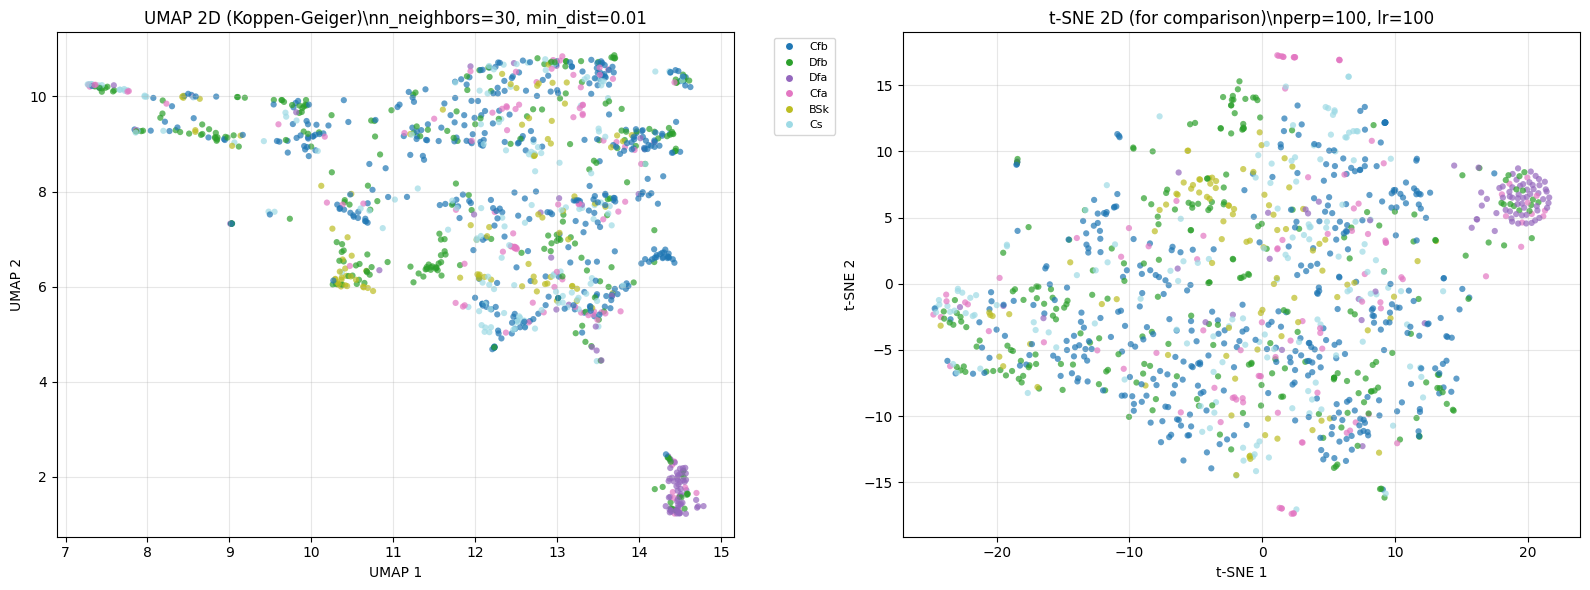

Saved interactive UMAP plot to ./Results/visualize_tsne\umap_best.html

✅ UMAP analysis complete! Check ./Results/visualize_tsne for saved results.
📋 Summary: UMAP often preserves local neighborhoods better than t-SNE
    Higher trustworthiness usually indicates better structure preservation


In [14]:
# --- UMAP Embedding for Better Geographic Preservation ---
# UMAP often preserves both local and global structure better than t-SNE

try:
    import umap
    print("UMAP library found!")
except ImportError:
    print("Installing UMAP...")
    # import subprocess
    # import sys
    # subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn"])
    # import umap
    # print("UMAP installed and imported!")

# UMAP parameters to try (more conservative than t-SNE)
UMAP_PARAMS = [
    {'n_neighbors': 15, 'min_dist': 0.1, 'n_components': 2},
    {'n_neighbors': 30, 'min_dist': 0.1, 'n_components': 2}, 
    {'n_neighbors': 50, 'min_dist': 0.1, 'n_components': 2},
    {'n_neighbors': 15, 'min_dist': 0.01, 'n_components': 2},
    {'n_neighbors': 30, 'min_dist': 0.01, 'n_components': 2}
]

# Also try higher dimensional UMAP embeddings
UMAP_PARAMS_3D = [
    {'n_neighbors': 15, 'min_dist': 0.1, 'n_components': 3},
    {'n_neighbors': 30, 'min_dist': 0.1, 'n_components': 3},
]

print(f"Running UMAP with {len(UMAP_PARAMS)} 2D parameter sets and {len(UMAP_PARAMS_3D)} 3D parameter sets...")

umap_results = []
UMAP_INPUT = X_pca  # Use same input as t-SNE for fair comparison

# Run 2D UMAP embeddings
for i, params in enumerate(UMAP_PARAMS):
    print(f"UMAP 2D {i+1}/{len(UMAP_PARAMS)}: n_neighbors={params['n_neighbors']}, min_dist={params['min_dist']}")
    
    t0 = time.time()
    reducer = umap.UMAP(
        n_neighbors=params['n_neighbors'],
        min_dist=params['min_dist'], 
        n_components=params['n_components'],
        random_state=RANDOM_STATE,
        verbose=False
    )
    
    Y_umap = reducer.fit_transform(UMAP_INPUT)
    runtime = time.time() - t0
    
    # Calculate trustworthiness for comparison with t-SNE
    tw = trustworthiness(UMAP_INPUT, Y_umap, n_neighbors=12)
    
    result = {
        'method': 'UMAP',
        'n_neighbors': params['n_neighbors'],
        'min_dist': params['min_dist'],
        'n_components': params['n_components'],
        'runtime_sec': runtime,
        'trustworthiness': tw,
        'embedding': Y_umap
    }
    umap_results.append(result)
    
    # Save intermediate result
    np.savez_compressed(
        os.path.join(OUT_DIR, f'umap_n{params["n_neighbors"]}_d{params["min_dist"]}_2d.npz'), 
        Y=Y_umap
    )
    
    print(f'  Done! Runtime: {runtime:.1f}s, Trustworthiness: {tw:.3f}')

# Run 3D UMAP embeddings  
for i, params in enumerate(UMAP_PARAMS_3D):
    print(f"UMAP 3D {i+1}/{len(UMAP_PARAMS_3D)}: n_neighbors={params['n_neighbors']}, min_dist={params['min_dist']}")
    
    t0 = time.time()
    reducer = umap.UMAP(
        n_neighbors=params['n_neighbors'],
        min_dist=params['min_dist'],
        n_components=params['n_components'], 
        random_state=RANDOM_STATE,
        verbose=False
    )
    
    Y_umap_3d = reducer.fit_transform(UMAP_INPUT)
    runtime = time.time() - t0
    
    # Calculate trustworthiness
    tw = trustworthiness(UMAP_INPUT, Y_umap_3d, n_neighbors=12)
    
    result = {
        'method': 'UMAP',
        'n_neighbors': params['n_neighbors'],
        'min_dist': params['min_dist'],
        'n_components': params['n_components'],
        'runtime_sec': runtime,
        'trustworthiness': tw,
        'embedding': Y_umap_3d
    }
    umap_results.append(result)
    
    # Save intermediate result
    np.savez_compressed(
        os.path.join(OUT_DIR, f'umap_n{params["n_neighbors"]}_d{params["min_dist"]}_3d.npz'), 
        Y=Y_umap_3d
    )
    
    print(f'  Done! Runtime: {runtime:.1f}s, Trustworthiness: {tw:.3f}')

# Create summary
umap_summary_df = pd.DataFrame([
    {k: v for k, v in r.items() if k != 'embedding'} for r in umap_results
])
print("\n=== UMAP Results Summary ===")
print(umap_summary_df.round(3))

# Save UMAP summary
umap_summary_df.to_csv(os.path.join(OUT_DIR, 'umap_summary.csv'), index=False)

# Find best UMAP result (highest trustworthiness)
best_umap_2d = max([r for r in umap_results if r['n_components'] == 2], key=lambda x: x['trustworthiness'])
best_umap_3d = max([r for r in umap_results if r['n_components'] == 3], key=lambda x: x['trustworthiness']) if any(r['n_components'] == 3 for r in umap_results) else None

print(f"\n🏆 Best 2D UMAP: n_neighbors={best_umap_2d['n_neighbors']}, min_dist={best_umap_2d['min_dist']}, trustworthiness={best_umap_2d['trustworthiness']:.3f}")
if best_umap_3d:
    print(f"🏆 Best 3D UMAP: n_neighbors={best_umap_3d['n_neighbors']}, min_dist={best_umap_3d['min_dist']}, trustworthiness={best_umap_3d['trustworthiness']:.3f}")

# Compare with t-SNE results
if len(results) > 0:
    best_tsne = max(results, key=lambda r: r['trustworthiness'])
    print(f"\n📊 Comparison:")
    print(f"Best t-SNE trustworthiness:  {best_tsne['trustworthiness']:.3f}")
    print(f"Best UMAP 2D trustworthiness: {best_umap_2d['trustworthiness']:.3f}")
    if best_umap_3d:
        print(f"Best UMAP 3D trustworthiness: {best_umap_3d['trustworthiness']:.3f}")
    
    improvement_2d = best_umap_2d['trustworthiness'] - best_tsne['trustworthiness']
    print(f"UMAP 2D improvement: {improvement_2d:+.3f}")
    
    if best_umap_3d:
        improvement_3d = best_umap_3d['trustworthiness'] - best_tsne['trustworthiness']
        print(f"UMAP 3D improvement: {improvement_3d:+.3f}")

# Visualize best UMAP results
print(f"\n📈 Creating UMAP visualizations...")

# Plot best 2D UMAP
Y_umap_best = best_umap_2d['embedding']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# UMAP colored by Koppen-Geiger
if 'Koppen-Geiger-Name-Modified' in filtered_meta_df.columns:
    labels = filtered_meta_df['Koppen-Geiger-Name-Modified'].astype(str).fillna('nan')
    unique_classes = list(dict.fromkeys(labels.tolist()))
    n_classes = max(1, len(unique_classes))
    cmap = plt.cm.get_cmap('tab20', min(n_classes, 20))
    class_to_color = {cls: cmap(i % cmap.N) for i, cls in enumerate(unique_classes)}
    
    for i, (x, y) in enumerate(Y_umap_best):
        cls = labels.iloc[i]
        col = class_to_color.get(cls, (0.5, 0.5, 0.5))
        axes[0].scatter(x, y, color=col, s=20, edgecolors='none', alpha=0.7)
    
    # Compact legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_to_color[cls], markersize=6) for cls in unique_classes]
    if len(handles) > 0:
        axes[0].legend(handles, unique_classes, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    axes[0].set_title(f'UMAP 2D (Koppen-Geiger)\\nn_neighbors={best_umap_2d["n_neighbors"]}, min_dist={best_umap_2d["min_dist"]}')
    axes[0].set_xlabel('UMAP 1')
    axes[0].set_ylabel('UMAP 2')
    axes[0].grid(True, alpha=0.3)

# Compare with t-SNE side by side
if len(results) > 0:
    Y_tsne_best = best_tsne['embedding']
    
    for i, (x, y) in enumerate(Y_tsne_best):
        cls = labels.iloc[i] if 'Koppen-Geiger-Name-Modified' in filtered_meta_df.columns else 'unknown'
        col = class_to_color.get(cls, (0.5, 0.5, 0.5)) if 'Koppen-Geiger-Name-Modified' in filtered_meta_df.columns else (0.5, 0.5, 0.5)
        axes[1].scatter(x, y, color=col, s=20, edgecolors='none', alpha=0.7)
    
    axes[1].set_title(f't-SNE 2D (for comparison)\\nperp={best_tsne["perplexity"]}, lr={best_tsne["learning_rate"]}')
    axes[1].set_xlabel('t-SNE 1') 
    axes[1].set_ylabel('t-SNE 2')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'umap_vs_tsne_comparison.png'), dpi=200, bbox_inches='tight')
plt.show()

# Create interactive UMAP plot
hover_text = [f"Key: {k}<br>KG: {filtered_meta_df['Koppen-Geiger-Name-Modified'].iloc[i]}" 
              for i, k in enumerate(filtered_embed_keys)]

fig_umap = px.scatter(x=Y_umap_best[:,0], y=Y_umap_best[:,1], 
                     color=filtered_meta_df['Koppen-Geiger-Name-Modified'].astype(str), 
                     hover_name=filtered_embed_keys.astype(str), 
                     hover_data=[filtered_meta_df['Koppen-Geiger-Name-Modified'].astype(str)],
                     color_discrete_sequence=px.colors.qualitative.Plotly,
                     title=f"UMAP Best (n_neighbors={best_umap_2d['n_neighbors']}, min_dist={best_umap_2d['min_dist']}, trust={best_umap_2d['trustworthiness']:.3f})")

html_path_umap = os.path.join(OUT_DIR, 'umap_best.html')
pio.write_html(fig_umap, file=html_path_umap, auto_open=False)
fig_umap.show()
print(f'Saved interactive UMAP plot to {html_path_umap}')

print(f"\n✅ UMAP analysis complete! Check {OUT_DIR} for saved results.")
print(f"📋 Summary: UMAP often preserves local neighborhoods better than t-SNE")
print(f"    Higher trustworthiness usually indicates better structure preservation")

C:\Users\andro\AppData\Local\Temp\ipykernel_46224\1102342378.py:42: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



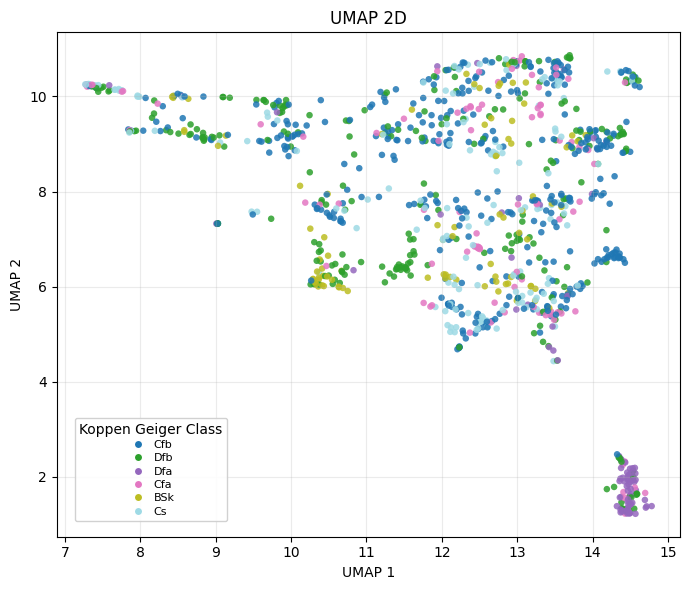

Saved standalone UMAP figures to: ./Results/visualize_tsne\umap_standalone.png/.pdf/.html


In [ ]:
# --- Standalone UMAP-only figure (separate from comparison) ---
# Reuse best UMAP 2D embedding if already computed; otherwise, load from summary or recompute minimal
import os
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

standalone_out_prefix = os.path.join(OUT_DIR, 'umap_standalone')

# Ensure we have best_umap_2d (from earlier cell) or derive it
if 'best_umap_2d' not in locals():
    summary_path = os.path.join(OUT_DIR, 'umap_summary.csv')
    if os.path.exists(summary_path):
        import pandas as _pd
        _umap_summary_df = _pd.read_csv(summary_path)
        _umap_summary_df_2d = _umap_summary_df[_umap_summary_df['n_components'] == 2]
        if len(_umap_summary_df_2d) > 0:
            _best_row = _umap_summary_df_2d.sort_values('trustworthiness', ascending=False).iloc[0]
            cand_file = os.path.join(OUT_DIR, f"umap_n{_best_row['n_neighbors']}_d{_best_row['min_dist']}_2d.npz")
            if os.path.exists(cand_file):
                Y_umap_best = np.load(cand_file)['Y']
            else:
                print('Could not locate embedding file for best row; aborting standalone plot.')
        else:
            print('No 2D UMAP rows found in summary; aborting standalone plot.')
    else:
        print('No umap_summary.csv found; run UMAP cell first.')
else:
    Y_umap_best = best_umap_2d['embedding']

# Determine label column priority (prefer Koppen-Geiger modified, then ISO16_value)
label_col = None
if 'Koppen-Geiger-Name-Modified' in filtered_meta_df.columns:
    label_col = 'Koppen-Geiger-Name-Modified'
elif 'ISO16_value' in filtered_meta_df.columns:
    label_col = 'ISO16_value'

if label_col is not None and 'Y_umap_best' in locals():
    labels = filtered_meta_df[label_col].astype(str).fillna('nan')
    unique_classes = list(dict.fromkeys(labels.tolist()))
    n_classes = max(1, len(unique_classes))
    cmap = plt.cm.get_cmap('tab20', min(n_classes, 20))
    class_to_color = {cls: cmap(i % cmap.N) for i, cls in enumerate(unique_classes)}

    fig, ax = plt.subplots(figsize=(7,6))
    for i, (x, y) in enumerate(Y_umap_best):
        cls = labels.iloc[i]
        ax.scatter(x, y, color=class_to_color.get(cls, (0.5,0.5,0.5)), s=22, edgecolors='none', alpha=0.85)

    # Legend inside bottom-left
    handles = [plt.Line2D([0],[0], marker='o', color='w', markerfacecolor=class_to_color[c], markersize=6, linestyle='') for c in unique_classes]
    if handles:
        ax.legend(handles, unique_classes,
                  loc='lower left',
                  title= 'Koppen Geiger Class',
                  bbox_to_anchor=(0.02, 0.02),
                  frameon=True,
                  framealpha=0.9,
                  fontsize=8,
                  borderpad=0.4,
                  labelspacing=0.3,
                  handletextpad=0.4)
    ax.set_title(
        f'UMAP 2D'
        if 'best_umap_2d' in locals() else 'UMAP 2D'
    )
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.savefig(standalone_out_prefix + '.png', dpi=300, bbox_inches='tight')
    plt.savefig(standalone_out_prefix + '.pdf', dpi=300, bbox_inches='tight')
    plt.show()

    # Interactive version with legend positioned bottom-left using layout margins
    fig_int = px.scatter(x=Y_umap_best[:,0], y=Y_umap_best[:,1],
                         color=labels,
                         hover_name=filtered_meta_df['embed_key'].astype(str),
                         title=f'Standalone UMAP 2D ({label_col})')
    fig_int.update_layout(legend=dict(yanchor='bottom', y=0.01, xanchor='left', x=0.01, bgcolor='rgba(255,255,255,0.85)', bordercolor='rgba(0,0,0,0.2)', borderwidth=1, font=dict(size=10)))
    fig_int.write_html(standalone_out_prefix + '.html')
    print('Saved standalone UMAP figures to:', standalone_out_prefix + '.png/.pdf/.html')
else:
    print('Standalone UMAP figure skipped: missing embedding or label column.')